<a href="https://colab.research.google.com/github/Uros-Males/Minimization_Problem_On_Identical_Machines_Analysis/blob/main/XHARDPermutation_Feature_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time


df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis(1) (1).csv')
df2 = df[df['train'] == 1]
print(df2['y'].max())
ymax_train1 = df2['y'].max()
# sve sa train = 0 y = max(y) + 1

for i in range(df.shape[0]):
  if(df.iloc[i]['train'] == 0):
    df.loc[i, 'y'] = ymax_train1 + 1

lower_bound = df['n'] * df['av.length'] / df['m']
lower_bound = lower_bound.astype('int') + 1

upper_bound = np.minimum(df[' LPTUB'], df[' SLACKUB'])
df['rel. bound'] = (upper_bound-lower_bound)/(upper_bound)
df['rel. bound'] = df['rel. bound']*10000

df['category'] = df['y']
for i in range(df.shape[0]):
  #print(df.iloc[i]['y'])
  if(df.iloc[i]['y'] < 1):
    df.loc[i, 'category'] = 0
  elif(df.iloc[i]['y'] >= 1 and df.iloc[i]['y'] < 10):
    df.loc[i, 'category'] = 1
  else:
    df.loc[i, 'category'] = 2

print(df['category'].max())
print(df['y'].max())
df = df[df['y']>=10]


shuffled = df.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name', 'CPLEXStatus','type','train', ' LPTUB', ' SLACKUB']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']

X['m/n'] = X['m/n'].apply(lambda x: x*100000)
X['(m/n)^2'] = X['(m/n)^2'].apply(lambda x: x*100000)
X['(m/n)^3'] = X['(m/n)^3'].apply(lambda x: x*100000)
shuffled = shuffled.drop([ 'index'], axis = 1)
print(X.head())

19.907111
2.0
20.907111
   subtype  class  indeks    n   m   n/m  (n/m)^2    (n/m)^3      m/n  \
0        3      6       3  160  64  2.50   6.2500  15.625000  40000.0   
1        3      4       8  200  80  2.50   6.2500  15.625000  40000.0   
2        4      7      10  176  64  2.75   7.5625  20.796875  36363.6   
3        4      7       1  220  80  2.75   7.5625  20.796875  36363.6   
4        4      7       3  220  80  2.75   7.5625  20.796875  36363.6   

   (m/n)^2  (m/n)^3   av.length     std.dev  median  range  min   max    k  \
0  16000.0   6400.0  394.225006  141.519485   385.5    473  163   636  137   
1  16000.0   6400.0  100.695000   18.155994   100.0    100   40   140   69   
2  13223.1   4808.4  696.380676  188.004608   705.0    964  223  1187  160   
3  13223.1   4808.4  881.549988  228.853409   887.5   1239  352  1591  186   
4  13223.1   4808.4  862.740906  219.114975   850.5   1141  228  1369  190   

    rel. bound  category  
0   380.487805       2.0  
1  1032.028470

In [2]:
from sklearn.preprocessing import StandardScaler

#sc = StandardScaler()
#X = sc.fit_transform(X)

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

regr = RandomForestRegressor(max_depth=20, random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, random_state=0)

In [3]:
from sklearn.metrics import mean_squared_error

rmse_full_mod = mean_squared_error(regr.predict(X_test), y_test, squared = False)

results = []

X = pd.DataFrame(X, columns=select)
X_test = pd.DataFrame(X_test, columns=X.columns)

for predictor in X_test:
    #print(predictor)
    X_test_copy = X_test.copy()
    #X_test_copy = X_test_copy.astype('int')
    
    X_test_copy[predictor] = X_test[predictor].sample(frac=1).values
    
    new_rmse = mean_squared_error(regr.predict(X_test_copy), y_test, squared = False)
    
    results.append({'pred': predictor,
                    'score': new_rmse - rmse_full_mod })

resultsdf = pd.DataFrame(results).sort_values(by = 'score', ascending = False)
resultsdf



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature n

,pred,score
12,std.dev,0.808563
18,rel. bound,0.274459
4,m,0.149252
15,min,0.121585
11,av.length,0.109118
2,indeks,0.100965
16,max,0.033111
14,range,0.024360
0,subtype,0.012296
5,n/m,0.012003


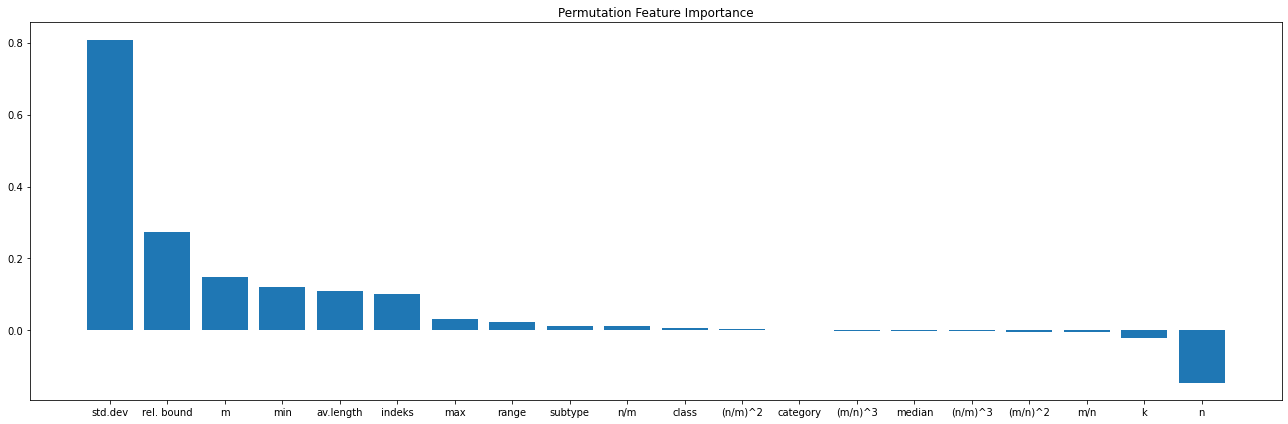

In [4]:
plt.figure(figsize=(18, 6))
plt.title('Permutation Feature Importance')
plt.bar(resultsdf.pred, resultsdf.score)
plt.tight_layout()
plt.show()